In [1]:
import sys

In [2]:
sys.path.append("../libs/basic_units/")

In [3]:
import numpy as np
import librosa
import python_speech_features
from basic_units import cm, inch
import matplotlib.pyplot as plt
from scipy.signal.windows import hann, hamming
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
n_mfcc = 12
n_mels = 40
n_fft = 16_384
hop_length = 2205
fmin = 0
fmax = None
winlen = 8192
rate = 44000

In [5]:
def read_file(file):
    file_contents = tf.io.read_file(file)
    return file, file_contents

In [6]:
filenames = tf.io.match_filenames_once('../data/audio_dataset/*.wav')
filename_ds = tf.data.Dataset.from_tensor_slices(filenames)

In [7]:
filename_contents_ds = filename_ds.map(read_file)

In [8]:
def get_next_chromagram(audio_file):
    print('filename %s ' % (audio_file))
    
    y, sr = librosa.core.load(audio_file)
    chroma_stft = librosa.feature.chroma_stft(y=y, hop_length=hop_length, n_fft=n_fft)
    
    return chroma_stft

In [9]:
def extract_feature_vector(chroma_data):
    num_features, num_samples = np.shape(chroma_data)
    
    print("Num features %d num samples %d " % (num_features, num_samples))
    
    freq_vals = tf.argmax(chroma_data)
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    
    return hist.astype(float) / num_samples

In [10]:
def get_dataset():
    filename_contents_ds_enum = filename_contents_ds.enumerate()
    
    xs = []
    for file_obj in filename_contents_ds_enum.as_numpy_iterator():
        chroma_data = get_next_chromagram(file_obj[1][0])
        
        x = [extract_feature_vector(chroma_data)]
        x = np.matrix(x)
        
        if len(xs) == 0:
            xs = x
        else:
            xs = np.vstack((xs, x))
    
    return xs

In [11]:
X = get_dataset()    
print(X)
print(X.shape)

filename b'../data/audio_dataset/cough_1.wav' 
Num features 12 num samples 12 
filename b'../data/audio_dataset/cough_2.wav' 
Num features 12 num samples 16 
filename b'../data/audio_dataset/scream_1.wav' 
Num features 12 num samples 13 
filename b'../data/audio_dataset/scream_2.wav' 
Num features 12 num samples 25 
filename b'../data/audio_dataset/scream_3.wav' 
Num features 12 num samples 34 
[[0.25       0.08333333 0.16666667 0.08333333 0.         0.
  0.         0.         0.16666667 0.25       0.         0.        ]
 [0.         0.         0.5625     0.125      0.         0.
  0.         0.         0.         0.         0.0625     0.25      ]
 [0.         0.         0.         0.         0.         0.30769231
  0.30769231 0.38461538 0.         0.         0.         0.        ]
 [0.         0.         0.04       0.04       0.92       0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.79411765 0.
  0.17647059 0.   

[ 0.03  1.03  2.03  3.03  4.03  5.03  6.03  7.03  8.03  9.03 10.03 11.03]


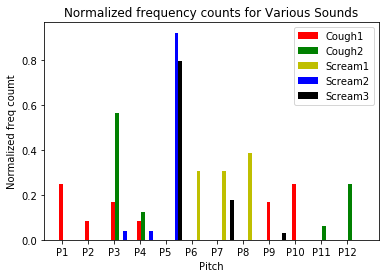

In [12]:
labels=[]
for i in np.arange(n_mfcc):
    labels.append("P"+str(i+1))
    
fig, ax = plt.subplots()
ind = np.arange(len(labels))
width = 0.15 
colors = ['r', 'g', 'y', 'b', 'black']
plots = []

for i in range(X.shape[0]):
    Xs = np.asarray(X[i]).reshape(-1)
    p = ax.bar(ind + (i * width), Xs, width, color=colors[i])
    plots.append(p[0])

xticks = ind + width / (X.shape[0])
print(xticks)


ax.legend(tuple(plots), ('Cough1', 'Cough2', 'Scream1', 'Scream2', 'Scream3'))
ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.set_ylabel('Normalized freq coumt')
ax.set_xlabel('Pitch')
ax.set_title('Normalized frequency counts for Various Sounds')
plt.show()